# Linear System Identification 
(testing on Lindblad Master Equation evolution)

In [1]:
using LinearAlgebra
using ControlSystems
using DifferentialEquations
using Plots


(process:8252): GLib-GIO-WARNING **: 10:30:30.729: Unexpectedly, UWP app `Microsoft.MSPaint_6.2203.1037.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.MSPaint_8wekyb3d8bbwe!Microsoft.MSPaint') supports 17 extensions but has no verbs


#### Description of algorithm

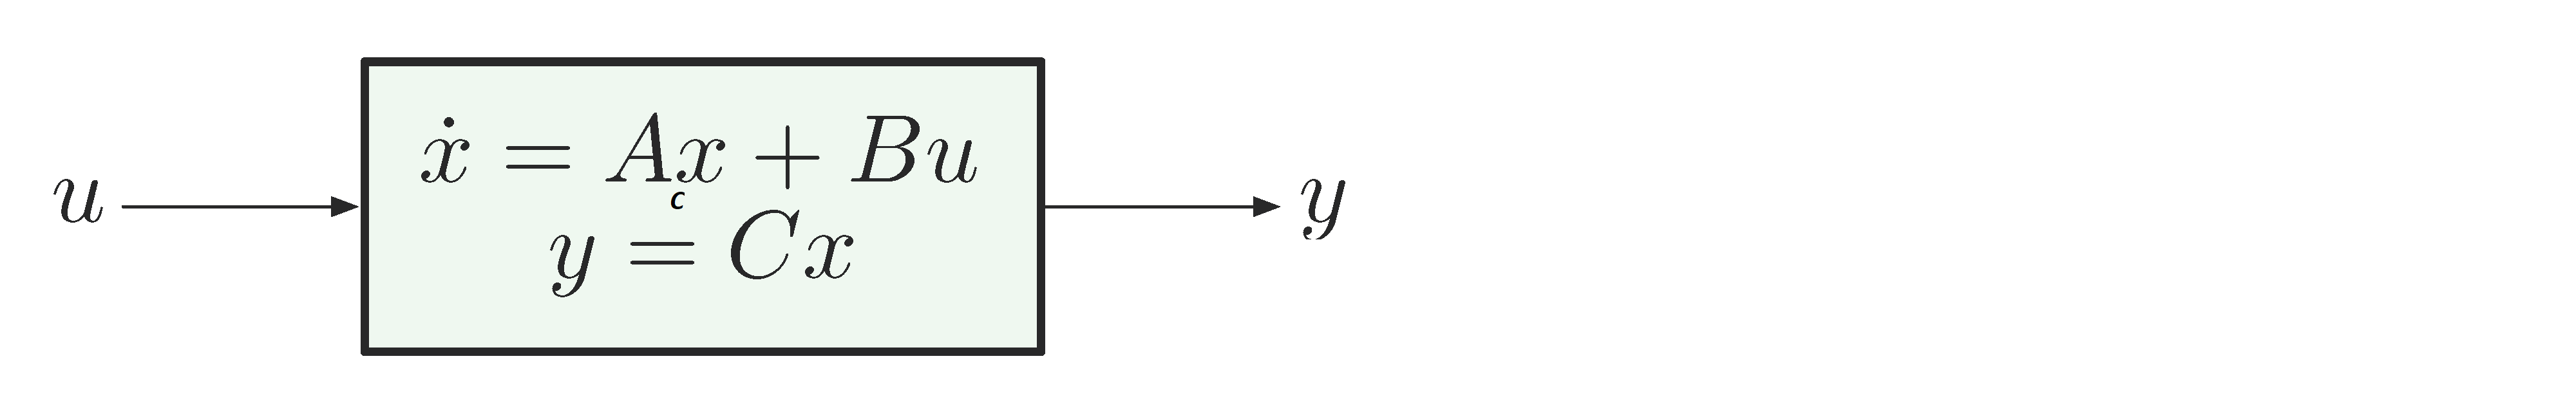

Consider LTI system with $n$-dimensional state vector $\mathbf{x}$, with  $m$-dimentional output vector $\mathbf{y}$ and no control ($u \equiv 0 $).

We have equation of motion and response:

\begin{align}
    \frac{d\mathbf{x}(t)} {dt} = A_c  \mathbf{x}(t) \label{Eq:SID:AEqMotion}
\end{align}

\begin{align}
    \mathbf{y}(t) = C \mathbf{x}(t) \label{Eq:SID:AOutput}
\end{align}


Given the initial conditions $\mathbf{x}(t_0) = \mathbf{x}(0)$ at some time $t=t_0=0$ and solving this equation of motion yields:
\begin{align}
    \mathbf{x}(t) = e^{A_c t}\mathbf{x}(0)  \notag
\end{align}

We use the equation of motion to introduce $A$ the field-free propagator:

\begin{align}\label{EqSIPropagatorsDefs}
    A = \exp(A_c \Delta t), 
    \\
     \operatorname{dim}[A] =  \operatorname{dim}[A_c] = n \times n \notag
\end{align}

the dynamics of the state vector reads as
\begin{align}
     \begin{cases}
        \mathbf{x}(0), & \\
        \mathbf{x}(\Delta t) &= A \mathbf{x}(0), \\
        \mathbf{x}(2\Delta t) &= A \mathbf{x}(\Delta t) = A^2 \mathbf{x}(0), \\
        &\vdots \notag\\
        \mathbf{x}(N \Delta t) &= A^N \mathbf{x}(0), \\
    \end{cases} \\
\end{align}

corresponding response $\mathbf{y}(t)$ is


\begin{align}
    \begin{cases}
        \mathbf{y}(0) &= C \mathbf{x}(0), \\
        \mathbf{y}(\Delta t) &=  CA\mathbf{x}(0),\\
        &\vdots \notag\\
        \mathbf{y}(N\Delta t) &= C A^N \mathbf{x}(0), \\
    \end{cases} \\
 \end{align}

Now consider the Hankel matrix $H$ of the outputs constructed in the following way:

$\begin{align} \label{EqHankMatrix}
    H = \left[
        \begin{array}{ccccc}
             \mathbf{y}(0)  &  \mathbf{y}(\Delta t)  & \dots &  \mathbf{y}(q\Delta t) \\
             \mathbf{y}(\Delta t)  &  \mathbf{y}(2\Delta t)  & \dots &  \mathbf{y}([q+1]\Delta t) \\
             \mathbf{y}(2\Delta t) &   \mathbf{y}(3\Delta t) & \dots &  \mathbf{y}([q+2]\Delta t) \\
             \vdots & \vdots &  & \vdots\\
              \mathbf{y}(q\Delta t) &  \mathbf{y}([q+1]\Delta t) & \dots &   \mathbf{y}(2q\Delta t) \\
        \end{array}
    \right] \notag 
    = \left[
        \begin{array}{ccccc}
             C\mathbf{x}(0)  &  CA\mathbf{x}(0)  & \dots &  C A^q \mathbf{x}(0) \\
             CA \mathbf{x}(0) &  C A^2 \mathbf{x}(0) & \dots &  C A^{q+1} \mathbf{x}(0)\\
             C A^2  \mathbf{x}(0) &   C A^3 \mathbf{x}(0)  & \dots &  C A^{q+2} \mathbf{x}(0)\\
             \vdots & \vdots &  & \vdots\\
              C A^q \mathbf{x}(0) &  C A^{q+1} \mathbf{x}(0) & \dots &   C A^{2q} \mathbf{x}(0) \\
        \end{array}
    \right]
\end{align}$

Function to build block Hankel matrix:

In [2]:
function hankel(y::AbstractArray)
    m, time_duration = size(y) # m - dimention of output vector y, time_duration - length of timeseries (number of time steps)
    q = Int(round(time_duration/2)) # q - is the size of Hankel matrix 
    H = zeros(eltype(y), q * m , q) 
    for r = 1:q, c = 1:q # r - rows, c -columns
        H[(r-1)*m+1:r*m, c] = y[:, r+c-1]
    end
    return H, m
end

hankel (generic function with 1 method)

It is obvious from the structure of the Hankel matrix $H$ that it can be represented as product of block matrices as follows:

\begin{align}
    H = \left[
        \begin{array}{ccccc}
             C   \\
             CA   \\
             CA^2  \\
             \vdots \\
             CA^q \\
        \end{array}
    \right]
    \left[
        \begin{array}{ccccc}
             I\mathbf{x}(0)  &  A\mathbf{x}(0)  & \dots &  A^q \mathbf{x}(0) \\
        \end{array}
    \right]
\end{align}

Lets consider Singular Value Decomposition of the Hankel matrix $H = \mathfrak{U} \Sigma \mathfrak{V^{\dagger}}$ to find the parts of product representation we are looking for:



\begin{align}
    U = \mathfrak{U} \sqrt{\Sigma} = \left[
        \begin{array}{ccccc}
             C   \\
             CA   \\
             CA^2  \\
             \vdots \\
             CA^q \\
        \end{array}
    \right] & &
V^{\dagger} = \sqrt{\Sigma} \mathfrak{V}^{\dagger} = 
     \begin{bmatrix}
    I \mathbf{x}(0)  & A \mathbf{x}(0) &  \dots & A^q \mathbf{x}(0)  
     \end{bmatrix} \\
\end{align}
$\operatorname{dim}[V^{\dagger} ] = n \times q \notag$

$C$ = the first $m$ rows of $U$

\begin{align}
    U_{\uparrow} = \left[
        \begin{array}{c}
            { C   }\\
            { CA  }\\
             \vdots \\
             {C A^{q-1}  }
        \end{array}
    \right]
\end{align}

\begin{align}
    U_{\downarrow} = \left[
        \begin{array}{c}
            { CA   }\\
            { CA^2  }\\
             \vdots \\
             {C A^{q}  }
        \end{array}
    \right] = U_{\uparrow} A
\end{align}


\begin{align}
     \operatorname{dim}[U_{\uparrow}] = \operatorname{dim}[U_{\downarrow}] = m[q-1] \times n \notag
\end{align}

Matrix $A$ of the system could be found just as a product of pseudo inverse of $U_{\uparrow}$ and $U_{\downarrow}$, and matrix $A_c$ as a matrix logarithm of $A$ divided by time step $\Delta t$:

\begin{align}
    A = U_{\uparrow}^{pinv}  U_{\downarrow} \\
    A_c = \frac{\log A}{\Delta t} \label{eq: Ac}
\end{align}


We can also find initial state of the system in a following way:

\begin{align} \label{EqHank1Matrix}
    H_0 = \left[
        \begin{array}{ccccc}
             \mathbf{y}(0\Delta t)   \\
             \mathbf{y}(1\Delta t)   \\
             \mathbf{y}(2\Delta t)  \\
             \vdots \\
              \mathbf{y}(q\Delta t)  \\
        \end{array}
    \right]
    = \left[
        \begin{array}{ccccc}
             C\mathbf{x}(0)   \\
             CA \mathbf{x}(0) \\
             CA^2  \mathbf{x}(0) \\
             \vdots \\
              C A^q \mathbf{x}(0) \\
        \end{array}
    \right]
    = U \mathbf{x}(0)
\end{align}




\begin{align}
\mathbf{x}(0) = U^{pinv} H_0 
\end{align}

### Main Linear System Identification function

To make function a litle bit faster we remove calculation of Ac by matrix logarithm as we use only propagator A and don't need Ac for our task

In [3]:
using LinearAlgebra

function lsid_ACx0(Y::AbstractArray, Δt, δ = 1e-6) 
    # y - output time series dim[y] = m x number_of_time_steps
    # δ - precission cutoff all the smaller values of Σ will be discarded 
    
    H, m = hankel(Y) # Hankel matrix and dimention of output (should be 12 in our case)
    U, Σ, Vd = svd(H) # Singular value decomposition of H to U,  Σ,  V†
    
    s = Diagonal(sqrt.(Σ)) # Matrix square root 
    U = U * s
    Vd = s * Vd
     
    n = argmin(abs.(Σ/maximum(Σ) .- δ)) - 1 # estimated rank of the system
    
    C = U[1:m, 1:n] # m -dimention of output, n - rank of the system
    
    U_up = U[1:end-m, :] # U↑
    U_down = U[m+1:end, :] # U↓
    
    A = pinv(U_up) * U_down
    # Ac = log(A)/Δt 
    # Ac = Ac[1:n, 1:n] 
    A = A[1:n, 1:n] # n - estimated rank of the system
    
    x0 = pinv(U) * H
    x0 = x0[1:n, 1]
    
    return A, C, x0 # was A, Ac, C, x0

end

lsid_ACx0 (generic function with 2 methods)

### Check  of System Identification accuracy for Lindblad evolution

Declare auxilary functions to generate random density matrix and Hamiltonian

In [4]:
using LinearAlgebra

function rand_dm(n)
    # return a random density matrix
    ρ = rand(n, n) + im * rand(n, n)
    ρ = ρ * ρ'
    Hermitian(ρ / tr(ρ))
end

function rand_herm(n)
    # return a random hermitian matrix
    h = rand(n, n) + im * rand(n, n)
    h = 0.5 * (h + h')
    Hermitian(h)
end

rand_herm (generic function with 1 method)

Lets set up 2-level basis for the quantum system using the QuantumOptics.jl package:

In [5]:
using QuantumOptics

basis = NLevelBasis(2) # define 2-level basis
ψ₀ = nlevelstate(basis, 1)  # ground state
ψ₁ = nlevelstate(basis, 2);  # excited state

The dynamics of open quantum systems are governed by a master equation in Lindblad form:

\begin{align}
    \dot{\rho} = \mathcal{L}(\rho) = - \frac{i}{h} [H,\rho] + \sum_i \left ( J_i \rho J_i^\dagger - \frac{1}{2} J_i^\dagger J_i \rho - \frac{1}{2} \rho J_i^\dagger J_i \right )
\end{align}

Set random seed

In [6]:
using Random
seed = 100
Random.seed!(seed)

TaskLocalRNG()

Set all parameters for simulation:

In [7]:
tₘₐₓ = 100.0 # maximum time 
Δt = 0.1     # time step
tlist = [0:Δt:tₘₐₓ;] # time span
ρ₀ = DenseOperator(basis, rand_dm(2))  # initial state density matrix
H = DenseOperator(basis, rand_herm(2)) # Hamiltonian of the system
J = DenseOperator(basis,rand(2, 2) + 1im*rand(2, 2))

Operator(dim=2x2)
  basis: NLevel(N=2)
 0.879343+0.71074im   0.680845+0.647396im
 0.177081+0.284346im  0.373748+0.180308im

Run the function from the QuantumOptics.jl package https://docs.qojulia.org/timeevolution/master/ for the Lindblad master equation simulation:

In [8]:
# time, ρ = timeevolution.master(tlist, ρ₀, H, [J]);
evol = timeevolution.master(tlist, ρ₀, H, [J])
time = evol[1]
ρ = evol[2];

#### Declare function to convert density matrix time series to Bloch vector time series

On each step consider bloch vector decomposition of density matrix by Pauli matrices:
\begin{align}
    b_t = \left(
        \begin{array}{c}
            { Tr(\rho_t \sigma_1)  }\\
            { Tr(\rho_t \sigma_2   }\\
             {Tr(\rho_t \sigma_3)  }
        \end{array}
    \right)
\end{align}

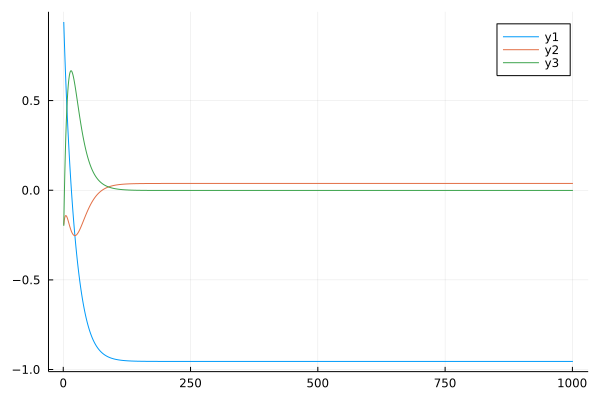

In [9]:
# Pauli matricies
σ = [
    [0 1; 1 0], [0 -im; im 0], [1 0; 0 -1], [1 0; 0 1]
];

function bloch(ρ)
    time_steps = length(ρ)
    bloch_vec = zeros(3, time_steps)
    for t in 1:time_steps
    bloch_vec[:, t] = [real(tr(σ[i] * ρ[t].data)) for i=1:3]
    end
    bloch_vec
end

bloch_vec = bloch(ρ)
plot(bloch_vec')

Perform Linear system identification with the function declared in the begining of notebook:

In [10]:
A_sid, C_sid, x0_sid  = lsid_ACx0(bloch_vec, Δt); # δ = 1e-6

#### Declare the propagator function (considering internal evolution linear)

Use matrix $A$ to propagate state vector of the system from $x_t$ to $x_{t+1}$ on each step:
\begin{align}
    A = \exp(A_c \Delta t)\\
    x_{t+1} = A x_t
\end{align}

In [11]:
function propagate(A, C, x0, steps)
    n = size(A, 1)
    @assert size(x0,1) == n
    y = zeros(size(C,1), steps) 
    xₜ = x0
    for t in 1:steps
        y[:, t] = C * xₜ
        xₜ = A * xₜ
    end
    return y
end 

propagate (generic function with 1 method)

Propagate Bloch vector using function declared above

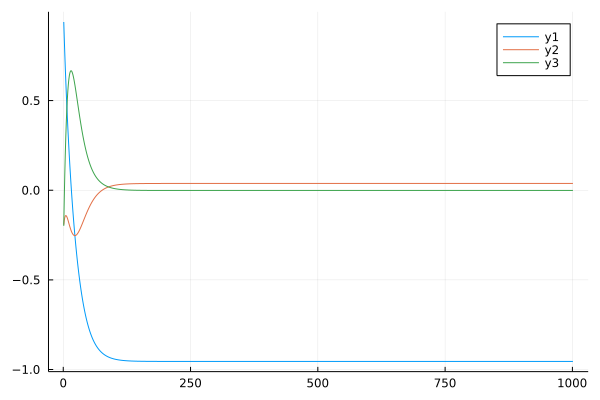

In [12]:
bloch_vec_sid = propagate(A_sid, C_sid, x0_sid, size(bloch_vec, 2))
plot(bloch_vec_sid')

Lets check SVD:

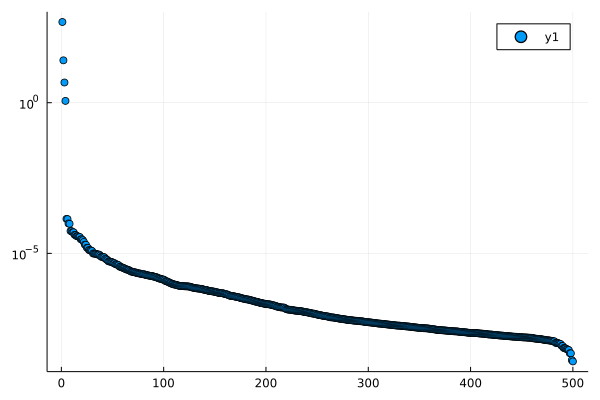

In [13]:
H, m = hankel(bloch_vec) # Hankel matrix and dimention of output (should be 12 in our case)
U, Σ, Vd = svd(H) # Singular value decomposition of H to U,  Σ,  V†
    
scatter(Σ, yaxis=:log)

And estimated rank of the system:

In [14]:
n = argmin(abs.(Σ/maximum(Σ) .- 1e-6)) - 1

4

Now compare dynamics of exact(original) block vector and simulated with identified model on the same plot

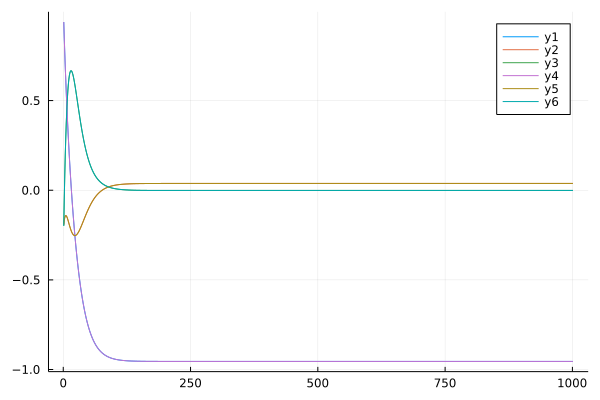

In [15]:
plot(bloch_vec')
plot!(bloch_vec_sid')

In [16]:
A_sid

4×4 Matrix{Float64}:
  1.00016       0.0023843  0.000528378  -0.000235315
 -0.00269893    0.966619   0.0192501     0.00489891
 -0.00170671   -0.0519904  0.895779     -0.0159695
  0.000794717   0.0211143  0.101721      0.894181

As we can see error is increasing over time but remain very low

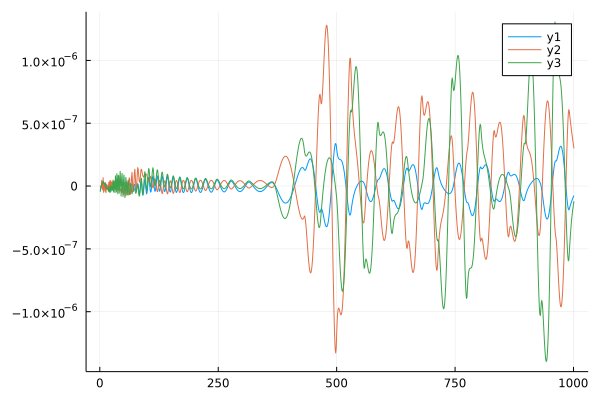

In [17]:
plot(bloch_vec' - bloch_vec_sid')

Check the maximum error

In [18]:
maximum(bloch_vec - bloch_vec_sid)

1.305867585042926e-6

Lets check maximum error on multiple random examples of Lindblad evolution
(for 10 samples it takes aprox. 5.7 seconds)

In [19]:
tₘₐₓ = 100.0 # maximum time 
Δt = 0.1     # time step
tlist = [0:Δt:tₘₐₓ;] # time span

number_of_samples = 1000

max_errors = zeros(number_of_samples)

@time for i in 1:number_of_samples
    
    ρ₀ = DenseOperator(basis, rand_dm(2))  # initial state density matrix
    H = DenseOperator(basis, rand_herm(2)) # Hamiltonian of the system
    J = DenseOperator(basis,rand(2, 2) + 1im*rand(2, 2)) # Lindblad decipator  
    
    evol = timeevolution.master(tlist, ρ₀, H, [J])
    time = evol[1]
    ρ = evol[2];
    
    bloch_vec = bloch(ρ)
        
    A_sid, C_sid, x0_sid  = lsid_ACx0(bloch_vec, Δt) # δ = 1e-6
    bloch_vec_sid = propagate(A_sid, C_sid, x0_sid, size(bloch_vec, 2))
    
    max_errors[i] = maximum(bloch_vec - bloch_vec_sid)
end
maximum(max_errors)

655.235395 seconds (269.98 M allocations: 131.722 GiB, 2.02% gc time)


9.817542546003422e-6

Plots below confirm that error remains very low for all samples

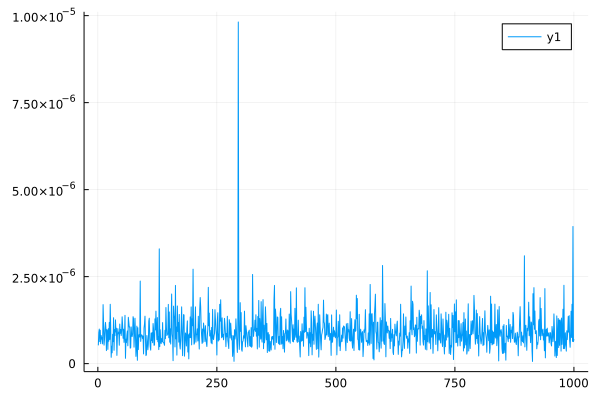

In [20]:
plot(max_errors)

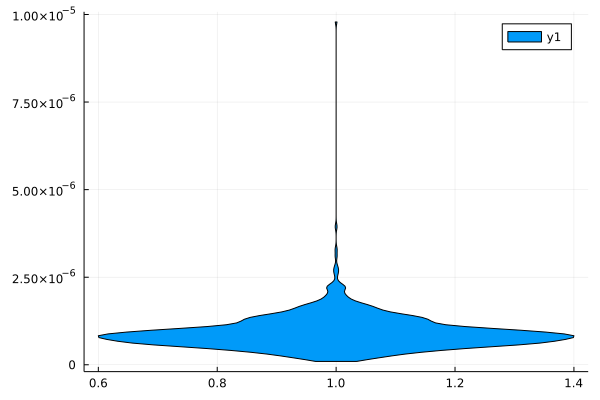

In [21]:
using StatsPlots
violin(max_errors)